In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('seaborn-talk')
from matplotlib import cm
import numpy as np
import os
import scipy.io
import seaborn as sb
from scipy.fftpack import fft
import csv
import pandas as pd
from scipy.signal import butter, filtfilt
import glob
import seaborn as sns
import scikit_posthocs as sp

In [2]:
# Pathways
outpath = r'C:\Users\Daniellab\Desktop\Jorge_Analysis\Tortuosity'
figpath = r'C:\Users\Daniellab\Desktop\Jorge_Analysis\Tortuosity\Figure'
source = r'C:\Users\Daniellab\Desktop\Jorge_Analysis\Centroids_Final\Raw_NG'
# outpath_2 = r'/Users/Mahad/Documents/GitHub2/ManducaMultiSenseFeeding/Tortuosity_Fig/Scatter/'

In [3]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

In [4]:
def jitter(number):
    j_int = number+0.1*np.random.randn(1)
    return j_int

In [5]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data, padlen = 2 * max(len(a), len(b)))
    return y

In [6]:
#  Here we implement a butterworth filter.  Kinda a useful beast for smoothing data.  
# We are creating a bandstop filter to get rid of wing beat frequesicies.

def butter_bandstop(fs, order=5):
    nyq = 0.5 * fs
    low = 22 / nyq
    high = 28 / nyq
    b, a = butter(order, [low, high], btype='bandstop', analog=False)
    return b, a

def butter_bandstop_filter(data, fs, order=5):
    b, a = butter_bandstop(fs, order=order)
    y = filtfilt(b, a, data, padlen = 2 * max(len(a), len(b)))
    return y

In [7]:
def GetStartStopFrame(test):
    test = np.asarray(test)
    c = np.where(np.isnan(test))[0]
    d = c[1:] - c[:-1] # find the edges where NaN's are - all continous NaNs will have 1 but non 
                    # contonous ones will have higher than 1
    if len(d) == 0:
        start_ind = 0
        stop_ind = len(test) - 1
    else:
        idx = np.argmax(d) # find the biggest continous block of non NaNs
        start_ind = c[idx] + 1 # start from one frame after the NaN
        stop_ind = c[idx + 1] - 1 # stop one frame before NaN

    return(start_ind, stop_ind)

In [8]:
def Tortuosity(df):
    
    pre_t = df.loc[:,'FrameNumber']
    t = pre_t/100
    xvel = df.loc[:,'X_position']
    yvel = df.loc[:,'Y_position']
    
    Nx = len(xvel)  #number of points
    Nt = Nx
    Time = t.values[-1]-t.values[0]   #total sample time (in seconds)c
    fs = Nx/Time   # sample frequency
    TT = 1/fs  #delta t.
    list(xvel)
    meanxvel = mean(xvel)
    
    # . fftxvel is complex with real and imaginary part.
    #Nyquist spacing (first half of Fourier) -- the list of frequencies for which we have Fourier coefficients
    fftxvel = fft(xvel-meanxvel)    # this is the Fourier tranform of the x velocity
    xf = np.linspace(0.0, 1.0/(2.0*TT), Nx//2)  
    
    order = 5
    cutoff = 5
    
    pre_conditioned_xvel = butter_bandstop_filter(xvel, fs, order)
    
    conditioned_xvel = butter_highpass_filter(pre_conditioned_xvel, cutoff, fs, order)

    
    stdxv = np.std(conditioned_xvel)
    meanxv = np.mean(xvel)
    turb_intens = stdxv/meanxv
    
    fft_Cxvel = fft(conditioned_xvel)
    
    return xf, Nx, fft_Cxvel, stdxv, meanxv, turb_intens, conditioned_xvel, list(xvel), list(yvel), list(t)

In [9]:
def Tortuosity_y(df):
    
    pre_t = df.loc[:,'FrameNumber']
    t = pre_t/100
    xvel = df.loc[:,'Y_position']
    yvel = df.loc[:,'Y_position']
    
    Nx = len(xvel)  #number of points
    Nt = Nx
    Time = t.values[-1]-t.values[0]   #total sample time (in seconds)c
    fs = Nx/Time   # sample frequency
    TT = 1/fs  #delta t.
    list(xvel)
    meanxvel = mean(xvel)
    
    # . fftxvel is complex with real and imaginary part.
    #Nyquist spacing (first half of Fourier) -- the list of frequencies for which we have Fourier coefficients
    fftxvel = fft(xvel-meanxvel)    # this is the Fourier tranform of the x velocity
    xf = np.linspace(0.0, 1.0/(2.0*TT), Nx//2)  
    
    order = 5
    cutoff = 5
    
    pre_conditioned_xvel = butter_bandstop_filter(xvel, fs, order)
    
    conditioned_xvel = butter_highpass_filter(pre_conditioned_xvel, cutoff, fs, order)

    
    stdxv = np.std(conditioned_xvel)
    meanxv = np.mean(xvel)
    turb_intens = stdxv/meanxv
    
    fft_Cxvel = fft(conditioned_xvel)
    
    return xf, Nx, fft_Cxvel, stdxv, meanxv, turb_intens, conditioned_xvel

In [10]:
csv_list = glob.glob(source + '\*Centroid*.csv')
print(len(csv_list))

52


In [11]:
csv_list

['C:\\Users\\Daniellab\\Desktop\\Jorge_Analysis\\Centroids_Final\\Raw_NG\\Centroids_Final_Experimental_1_150214.csv',
 'C:\\Users\\Daniellab\\Desktop\\Jorge_Analysis\\Centroids_Final\\Raw_NG\\Centroids_Final_Experimental_1_150970.csv',
 'C:\\Users\\Daniellab\\Desktop\\Jorge_Analysis\\Centroids_Final\\Raw_NG\\Centroids_Final_Experimental_1_52523.csv',
 'C:\\Users\\Daniellab\\Desktop\\Jorge_Analysis\\Centroids_Final\\Raw_NG\\Centroids_Final_Experimental_2_50448.csv',
 'C:\\Users\\Daniellab\\Desktop\\Jorge_Analysis\\Centroids_Final\\Raw_NG\\Centroids_Final_Experimental_3_47669.csv',
 'C:\\Users\\Daniellab\\Desktop\\Jorge_Analysis\\Centroids_Final\\Raw_NG\\Centroids_Final_Experimental_4_66232.csv',
 'C:\\Users\\Daniellab\\Desktop\\Jorge_Analysis\\Centroids_Final\\Raw_NG\\Centroids_Final_Experimental_4_72340.csv',
 'C:\\Users\\Daniellab\\Desktop\\Jorge_Analysis\\Centroids_Final\\Raw_NG\\Centroids_Final_Experimental_5_50032.csv',
 'C:\\Users\\Daniellab\\Desktop\\Jorge_Analysis\\Centroids_Fin

Experimental_1_150214


C:\Users\Daniellab\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


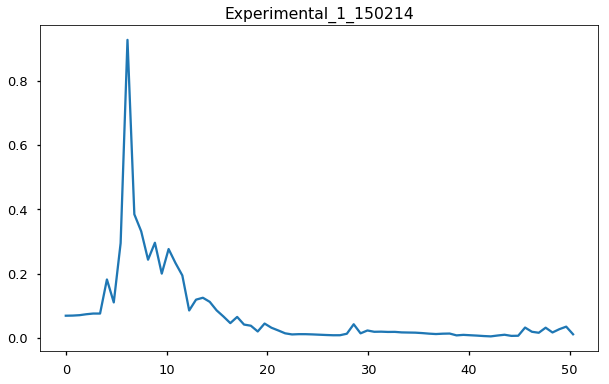

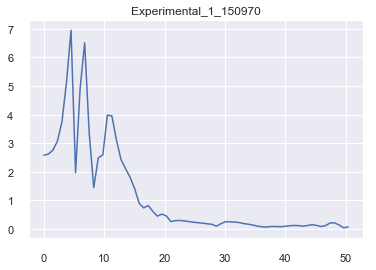

Experimental_1_52523


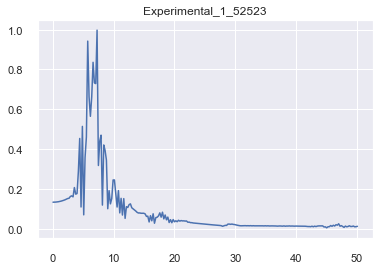

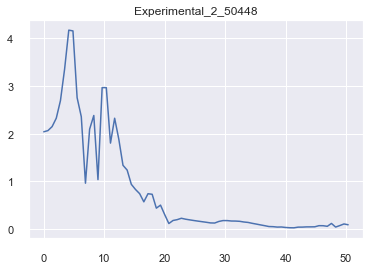

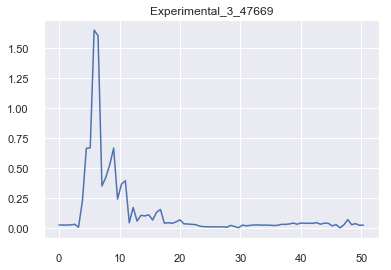

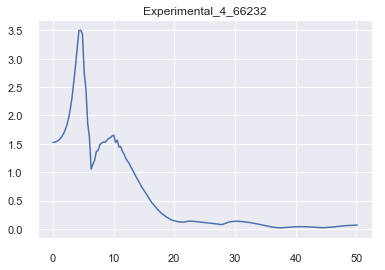

Experimental_4_72340


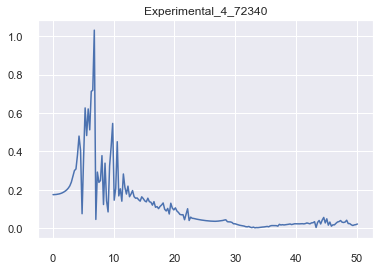

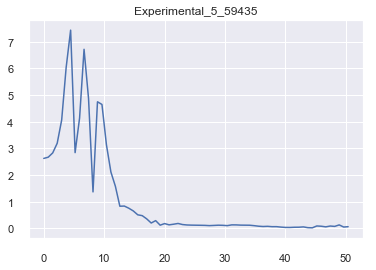

Experimental_7_36526


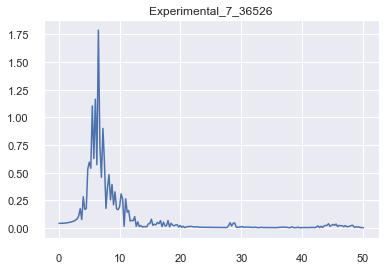

Experimental_7_40443


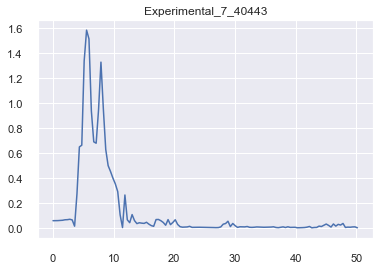

Experimental_7_41552


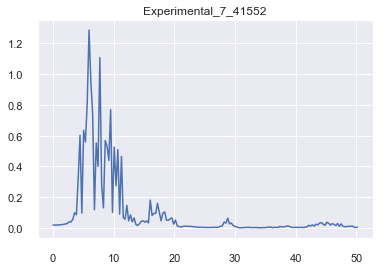

Experimental_7_54607


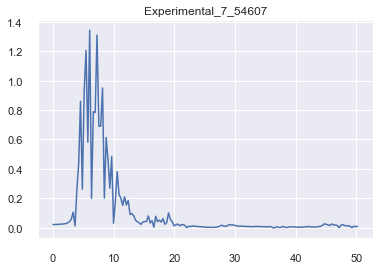

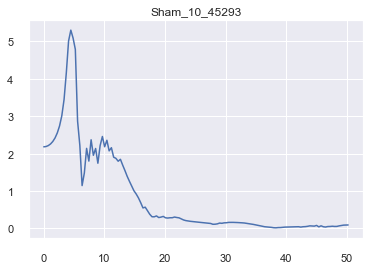

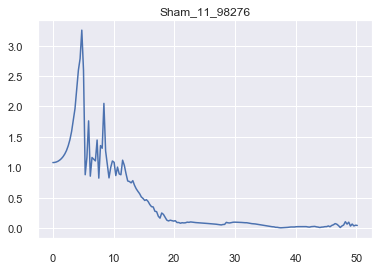

Sham_14_23923


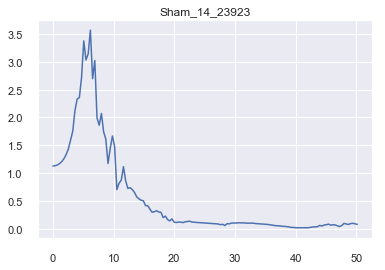

Sham_14_27298


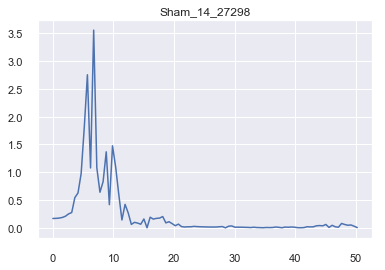

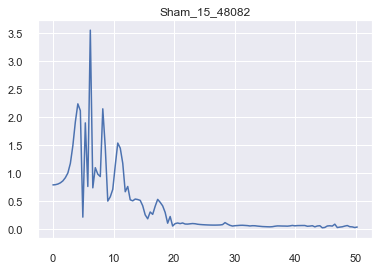

Sham_16_31431


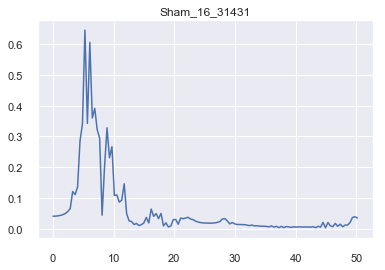

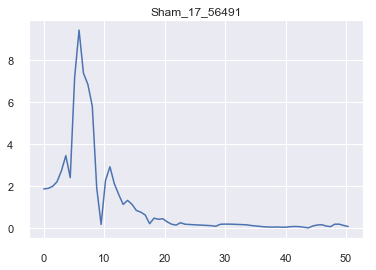

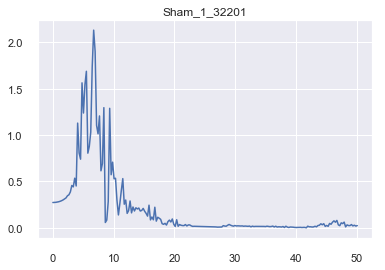

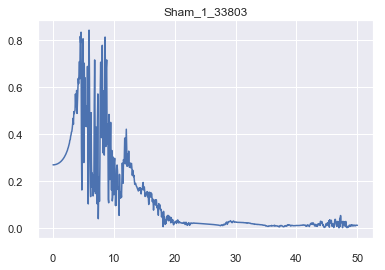

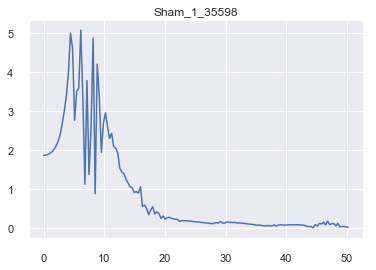

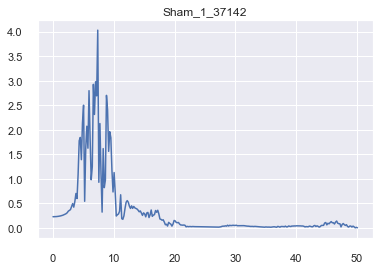

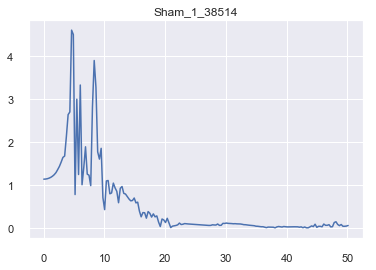

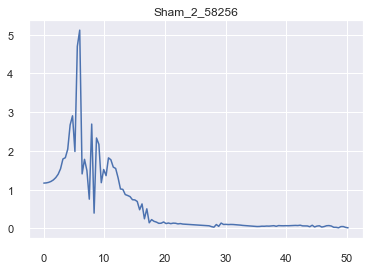

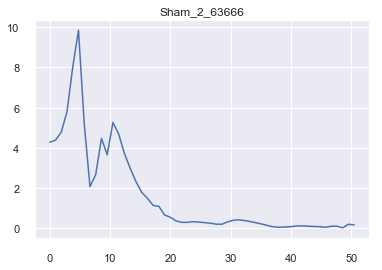

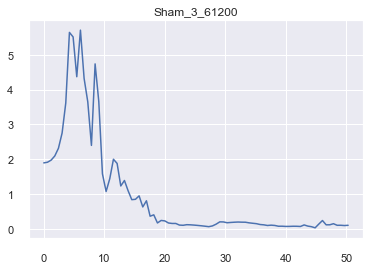

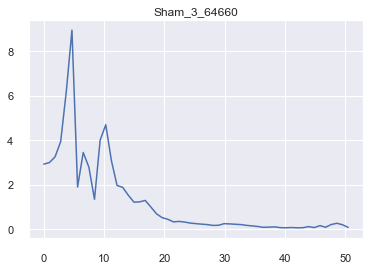

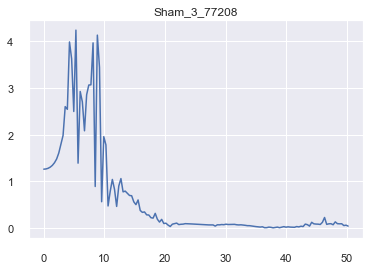

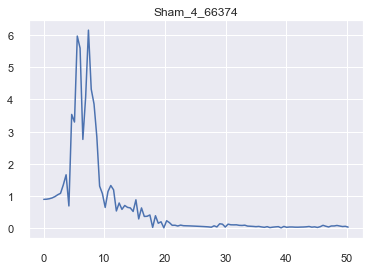

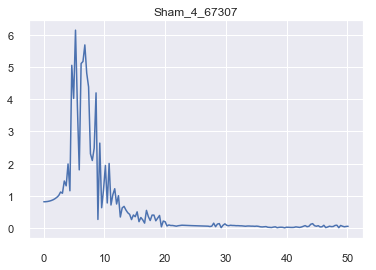

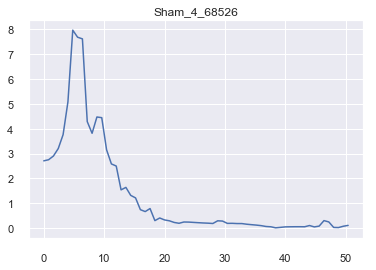

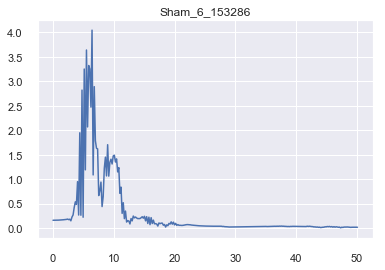

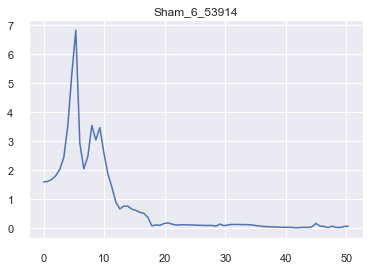

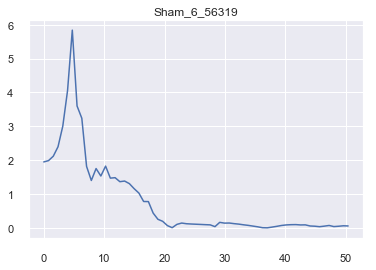

Sham_6_72273


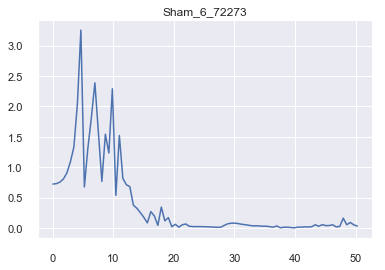

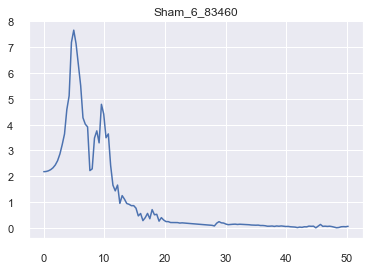

Sham_7_54387


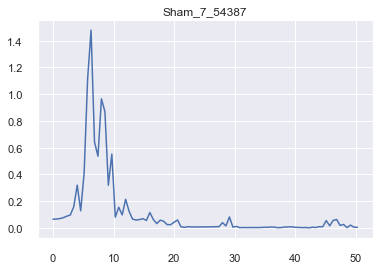

Sham_7_56021


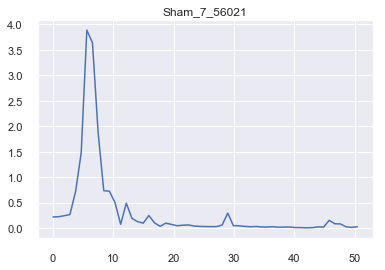

Sham_7_59103


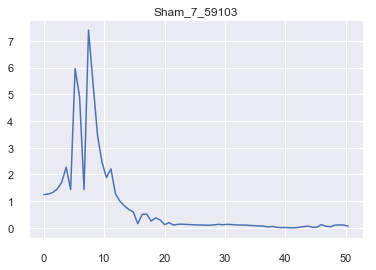

Sham_7_59901


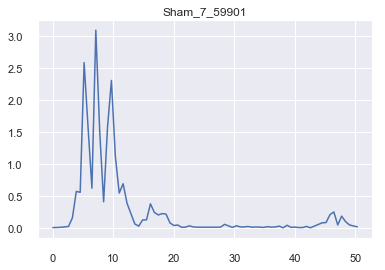

Sham_7_63837


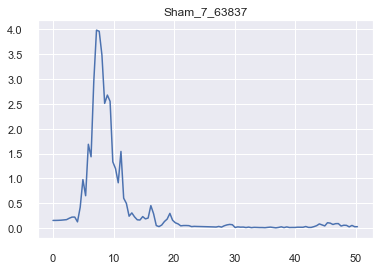

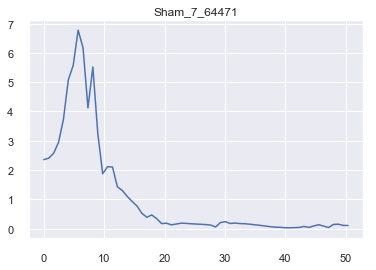

Sham_7_64994


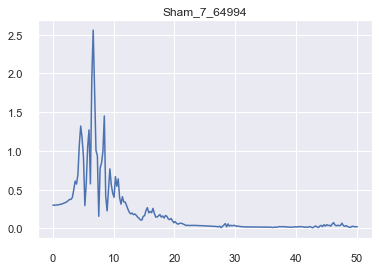

In [12]:
name_list = []
xf_list = []
Nx_list = []
fft_Cxvel_list = []
stdxv_list = []
meanxv_list = []
turb_intens_list = []
conditioned_xvel_list = []
xvel = []
yvel = []
t = []
window = []
visit_number_list = []
fig = plt.subplots(figsize = (10,6))

for element in csv_list:
    dFrame = pd.read_csv(element)
    xposition = dFrame.X_position
    start, stop = GetStartStopFrame(xposition)
    visit_number = dFrame.visit_number[0]
    if np.any(dFrame.X_position.isnull()):
        print(element[81:-4])
        
        
        
        a = np.asarray(np.where(dFrame.X_position.isnull())).ravel()
        b = a[1:]
        c = a[:-1]
        d = b-c
        last_chunk = len(xposition) - a[-1]
        
        
        if last_chunk > 100:
            start = a[-1]+1
            end = a[-1] + last_chunk-1
            
        elif a[0] > 100:
            start = 0
            end = a[0]-1
        
        
        elif d.max() > 100:
            e = d.argmax()
            start = a[e]+1
            end = a[e+1]-1
        
        else:
            print(element[81:-4], 'error')
        
        
        
        clipped_df = dFrame[start:end]
        w = end-start
    else:
        clipped_df = dFrame
    if len(clipped_df) > 100:
        xf, Nx, fft_Cxvel, stdxv, meanxv, turb_intens, conditioned_xvel, xvel, yvel, t = Tortuosity(clipped_df)

        name_list.append(element[81:-4])
        window.append(w)
        xf_list.append(xf)
        Nx_list.append(Nx)
        fft_Cxvel_list.append(fft_Cxvel)
        stdxv_list.append(stdxv)
        meanxv_list.append(meanxv)
        turb_intens_list.append(turb_intens)
        conditioned_xvel_list.append(conditioned_xvel)
        visit_number_list.append(visit_number)



        plt.plot(xf, 2.0/Nx * np.abs(fft_Cxvel[0:Nx//2]))
        plt.title(element[81:-4])
        plt.savefig(figpath + "\\" + element[81:-4] + '_x.png')
        plt.show()   
        sb.set()

Experimental_1_150214


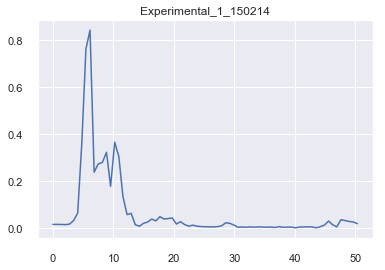

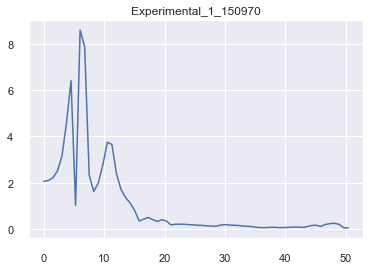

Experimental_1_52523


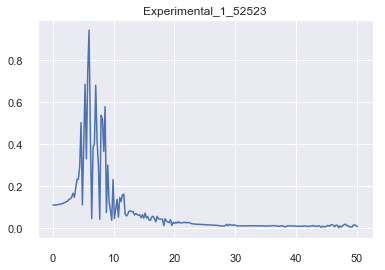

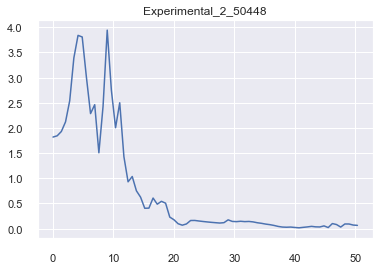

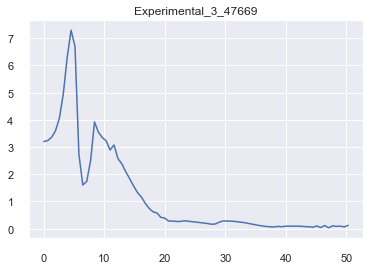

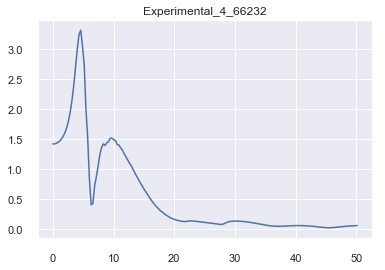

Experimental_4_72340


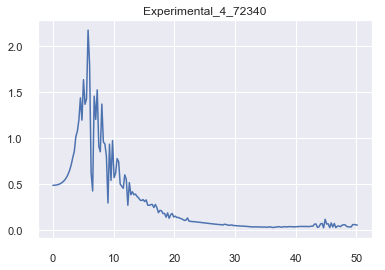

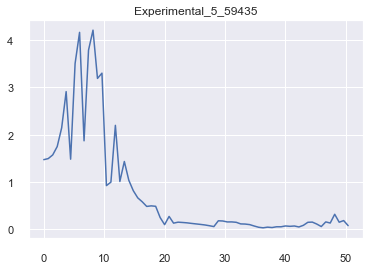

Experimental_7_36526


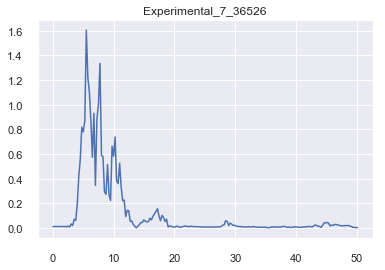

Experimental_7_40443


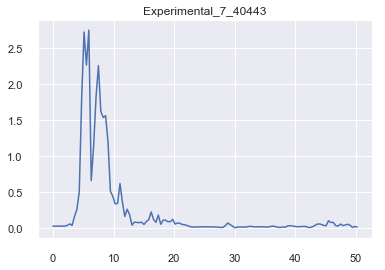

Experimental_7_41552


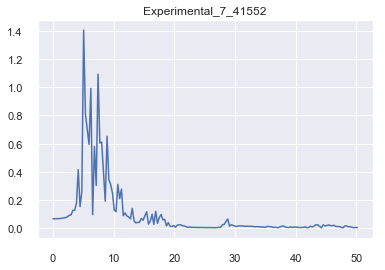

Experimental_7_54607


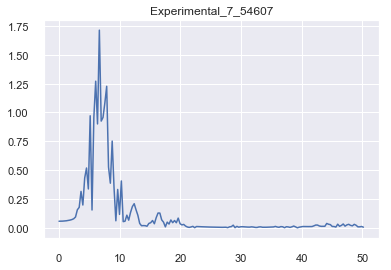

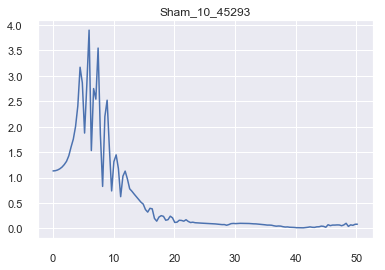

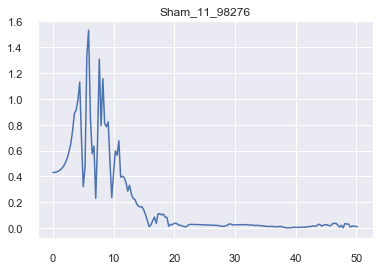

Sham_14_23923


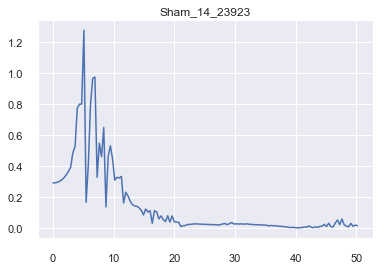

Sham_14_27298


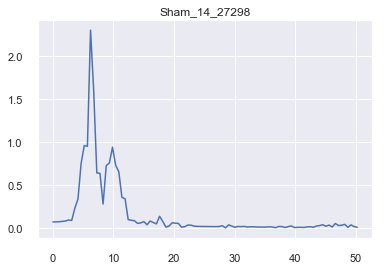

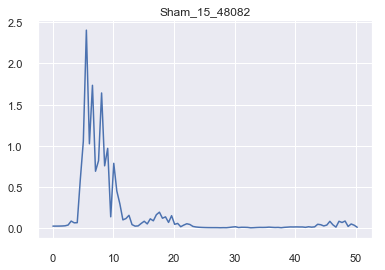

Sham_16_31431


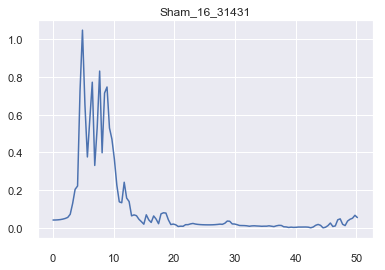

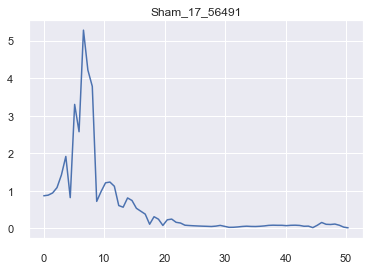

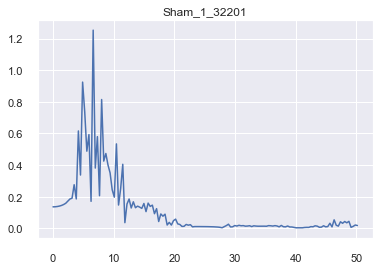

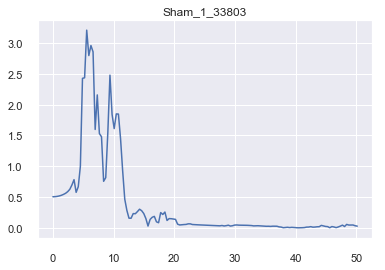

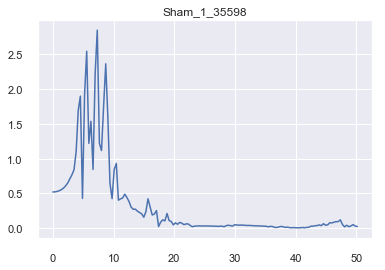

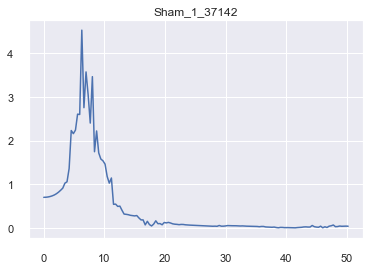

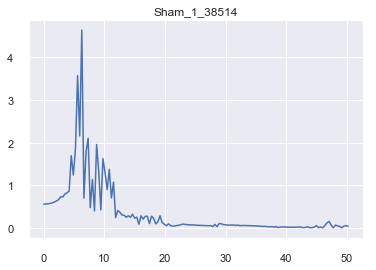

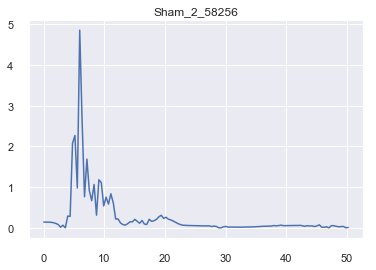

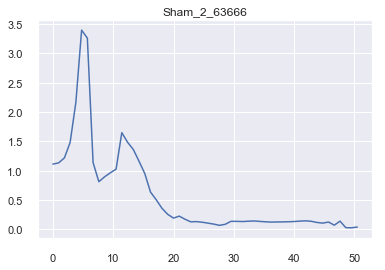

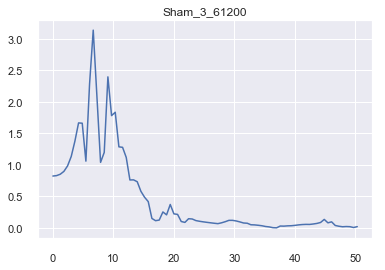

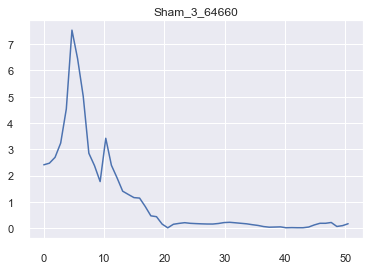

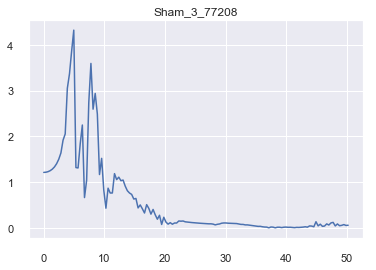

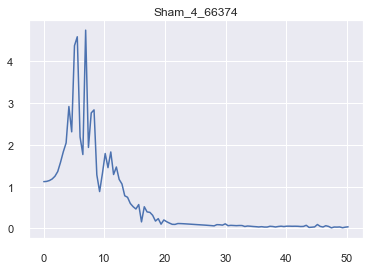

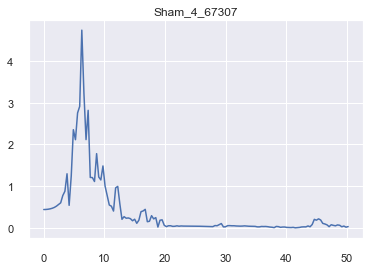

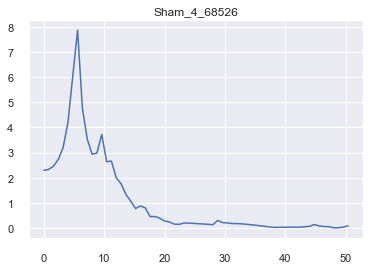

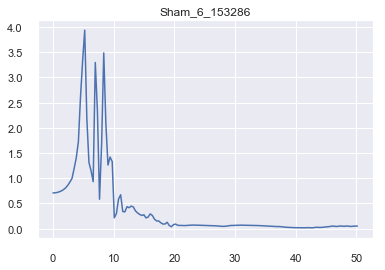

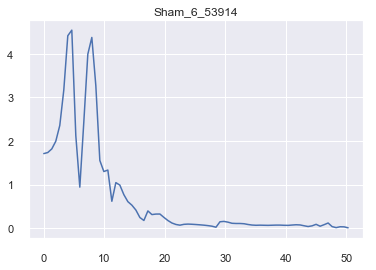

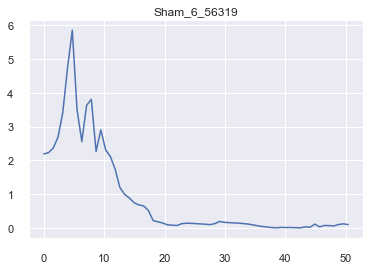

Sham_6_72273


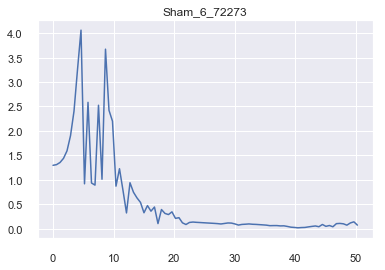

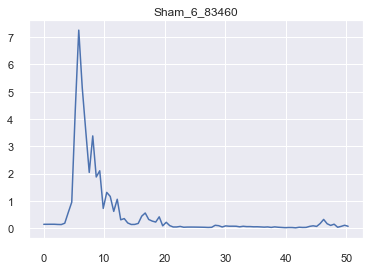

Sham_7_54387


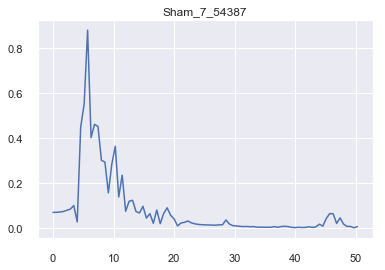

Sham_7_56021


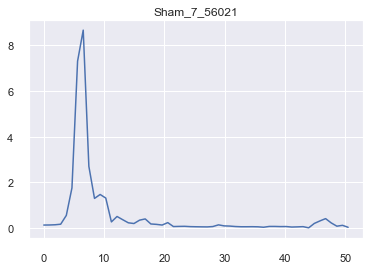

Sham_7_59103


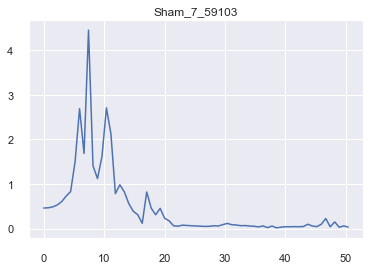

Sham_7_59901


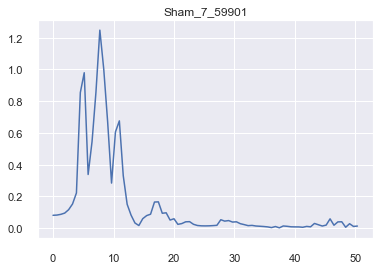

Sham_7_63837


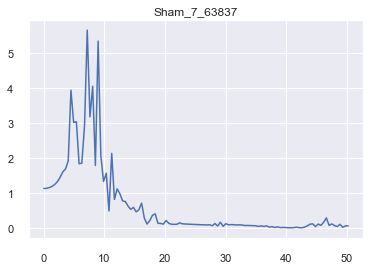

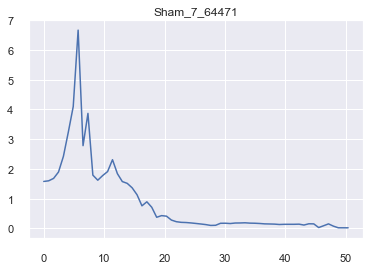

Sham_7_64994


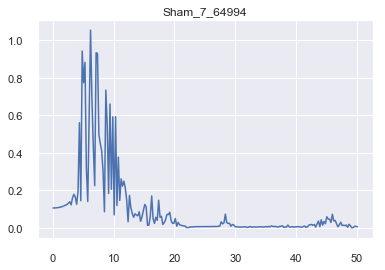

In [13]:
name_list = []
yf_list = []
Ny_list = []
fft_Cyvel_list = []
stdyv_list = []
meanyv_list = []
turb_y_intens_list = []
conditioned_yvel_list = []
visit_number_ylist = []

# fig = plt.subplots(figsize = (10,6))

for element in csv_list:
    
        dFrame = pd.read_csv(element)
        name = element[81:-4]

        yposition = dFrame.Y_position
        start, stop = GetStartStopFrame(yposition)
        visit_ynumber = dFrame.visit_number[0]
        if np.any(dFrame.Y_position.isnull()):
            print(name)


            a = np.asarray(np.where(dFrame.Y_position.isnull())).ravel()
            b = a[1:]
            c = a[:-1]
            d = b-c
            last_chunk = len(yposition) - a[-1]


            if last_chunk > 100:
                start = a[-1]+1
                end = a[-1] + last_chunk-1

            elif a[0] > 100:
                start = 0
                end = a[0]-1


            elif d.max() > 100:
                e = d.argmax()
                start = a[e]+1
                end = a[e+1]-1

            else:
                print(element[81:-4], 'error')



            clipped_df = dFrame[start:end]

        else:
            clipped_df = dFrame




        clipped_df = dFrame[start:end]
        if len(clipped_df) > 100:
            yf, Ny, fft_Cyvel, stdyv, meanyv, turb_y_intens, conditioned_yvel = Tortuosity_y(clipped_df)

            name_list.append(name)
            yf_list.append(yf)
            Ny_list.append(Ny)
            fft_Cyvel_list.append(fft_Cyvel)
            stdyv_list.append(stdyv)
            meanyv_list.append(meanyv)
            turb_y_intens_list.append(turb_y_intens)
            conditioned_yvel_list.append(conditioned_yvel)
            visit_number_ylist.append(visit_ynumber)

            plt.plot(yf, 2.0/Ny * np.abs(fft_Cyvel[0:Ny//2]))
            plt.title(name)
            plt.savefig(figpath + "\\" + element[81:-4] + '_y.png')
            plt.show()   
            sb.set()

In [14]:
name_list_ = []
for name in name_list:
    if name.startswith('L0.1_c-3_m'):
        name = name[:12]
        if name.endswith('_'):
            name = name[:-1]
        
    elif name.startswith('Sham'):
        name = name[:7]
        if name.endswith('_'):
            name = name[:-1]
    elif name.startswith('Experimental'):
        name = name[:15]
        if name.endswith('_'):
            name = name[:-1]
    
    name_list_.append(name)
#     print(name)
name_list = name_list_
name_list

['Experimental_1',
 'Experimental_1',
 'Experimental_1',
 'Experimental_2',
 'Experimental_3',
 'Experimental_4',
 'Experimental_4',
 'Experimental_5',
 'Experimental_7',
 'Experimental_7',
 'Experimental_7',
 'Experimental_7',
 'Sham_10',
 'Sham_11',
 'Sham_14',
 'Sham_14',
 'Sham_15',
 'Sham_16',
 'Sham_17',
 'Sham_1',
 'Sham_1',
 'Sham_1',
 'Sham_1',
 'Sham_1',
 'Sham_2',
 'Sham_2',
 'Sham_3',
 'Sham_3',
 'Sham_3',
 'Sham_4',
 'Sham_4',
 'Sham_4',
 'Sham_6',
 'Sham_6',
 'Sham_6',
 'Sham_6',
 'Sham_6',
 'Sham_7',
 'Sham_7',
 'Sham_7',
 'Sham_7',
 'Sham_7',
 'Sham_7',
 'Sham_7']

In [15]:
len(name_list), len(Nx_list), len(name_list), len(stdxv_list), len(meanyv_list), len(turb_intens_list)

(44, 44, 44, 44, 44, 44)

In [16]:
condition = ["Experimental"]*12
condition.extend(["Sham"]*32)
new_df = (pd.DataFrame({'name' : name_list, 'Nx' : Nx_list,
                            'stdxv': stdxv_list, 'meanxv' : meanxv_list
                       ,'turb_intens' : turb_intens_list, 'condition': condition, 'visit_number': visit_number_list}))
other_df = (pd.DataFrame({'xf' : xf_list, 'fft_Cxvel': fft_Cxvel_list, 'filterd_xvel' : conditioned_xvel_list}))



In [17]:
new_y_df = (pd.DataFrame({'name' : name_list, 'Ny' : Ny_list,
                            'stdyv': stdyv_list, 'meanyv' : meanyv_list
                       ,'turb_intens' : turb_y_intens_list, 'condition': condition, 'visit_number': visit_number_ylist}))
other_y_df = (pd.DataFrame({'yf' : yf_list, 'fft_Cyvel': fft_Cyvel_list, 'filterd_yvel' : conditioned_yvel_list}))

In [18]:
new_df.to_csv(r"C:\Users\Daniellab\Desktop\Jorge_Analysis\Tortuosity\bad_videos_removed" + r"\Tortuosity_Single_removed.csv")
other_df.to_csv(r"C:\Users\Daniellab\Desktop\Jorge_Analysis\Tortuosity\bad_videos_removed" + r"\tortuosity_Longer.csv")

In [19]:
new_y_df.to_csv(r"C:\Users\Daniellab\Desktop\Jorge_Analysis\Tortuosity\bad_videos_removed" + r"\Tortuosity_y_Single_removed.csv")
other_y_df.to_csv(r"C:\Users\Daniellab\Desktop\Jorge_Analysis\Tortuosity\bad_videos_removed" + r"\tortuosity_y_Longer.csv")

In [20]:
df = pd.read_csv(outpath + "\Tortuosity_Single.csv")

name_list = df.name


name_list

0     Experimental_1
1     Experimental_1
2     Experimental_1
3     Experimental_2
4     Experimental_2
5     Experimental_3
6     Experimental_4
7     Experimental_4
8     Experimental_5
9     Experimental_5
10    Experimental_7
11    Experimental_7
12    Experimental_7
13    Experimental_7
14           Sham_10
15           Sham_11
16           Sham_11
17           Sham_14
18           Sham_14
19           Sham_15
20           Sham_15
21           Sham_15
22           Sham_15
23           Sham_15
24           Sham_16
25           Sham_16
26           Sham_17
27           Sham_18
28            Sham_1
29            Sham_1
30            Sham_1
31            Sham_1
32            Sham_1
33            Sham_1
34            Sham_1
35            Sham_2
36            Sham_2
37            Sham_2
38            Sham_3
39            Sham_3
40            Sham_3
41            Sham_4
42            Sham_4
43            Sham_4
44            Sham_6
45            Sham_6
46            Sham_6
47           

In [21]:
df_y = pd.read_csv(outpath + "\Tortuosity_y_Single.csv")


name_y_list = df_y.name

print(len(name_y_list))

57


In [22]:
df.index 
df["visit_number"]

0     1
1     2
2     0
3     0
4     1
5     0
6     0
7     1
8     0
9     1
10    0
11    1
12    2
13    3
14    0
15    1
16    0
17    0
18    1
19    0
20    1
21    2
22    3
23    4
24    0
25    1
26    0
27    0
28    0
29    1
30    2
31    3
32    4
33    5
34    6
35    0
36    1
37    2
38    0
39    1
40    2
41    0
42    1
43    2
44    5
45    0
46    1
47    2
48    3
49    4
50    0
51    1
52    2
53    3
54    4
55    5
56    6
Name: visit_number, dtype: int64

In [23]:
i = 0
t_1 = []
t_2 = []
t_3 = []
t_4 = []
for name in unique_names:
    
    if name.startswith('Experimental'):
        print(name)
        Tortuosity = df_t[(df_t.name == name)].turb_intens.values
        t_val = Tortuosity
        t_1.append(t_val)
    elif name.startswith('Sham'):
        print(name)
        Tortuosity = df_t[(df_t.name == name)].turb_intens.values
        t_val_ = Tortuosity
        t_2.append(t_val_)
    elif name.startswith('L'):
        print(name)
        Tortuosity = df_t[(df_t.name == name)].turb_intens.values
        t_val__ = Tortuosity
        t_3.append(t_val__)
#     elif name.startswith('Pseudo'):
#         print(name)
#         Tortuosity = df[(df.name == name)].turb_intens
#         t_val___ = Tortuosity[i]
#         t_4.append(t_val___)
    i+=1
scipy.stats.kruskal(t_1,t_2,t_3)


NameError: name 'unique_names' is not defined

In [ ]:
t_1

In [ ]:
sp.posthoc_dunn(df_t,val_col = 'turb_intens', group_col = 'condition', p_adjust = 'Bonferroni')

In [ ]:
turb_list = []
for name in df.name.unique():
    turb = np.median(df[(df.name == name)].turb_intens.values)
    turb_list.append(turb)
len(turb_list), len(df.name.unique())

In [ ]:
unique_names = df.name.unique()
unique_conditions = ["Experimental"]*6
unique_conditions.extend(["Control"]*29)
unique_conditions.extend(["Sham"]*13)
df_t = pd.DataFrame({'turb_intens': turb_list, 'name': unique_names, 'condition': unique_conditions})
df_t

In [ ]:
sns.violinplot(x='condition', y ='turb_intens', data = df_t, inner="quart")
sns.swarmplot(x='condition', y ='turb_intens', data = df_t,
            size=5, color="0.2", linewidth=0)
# plt.title('Tortuosity', size = 30, weight = 'bold')
plt.xlabel('Condition', size = 20, weight = 'bold')
plt.ylabel('Tortuosity', size = 20, weight = 'bold')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.text(1.0, 0.15, 'p-value = 9.52e-05', weight = 'bold', size = 14)
plt.text(1.0, 0.13, '(Kruskal Test)', weight = 'bold', size = 14)
plt.tight_layout()
plt.savefig(figpath + "\Tortousity_Figure_1224.png")

In [ ]:
sns.violinplot(x='condition', y ='turb_intens', data = df_y, inner="quart")
sns.swarmplot(x='condition', y ='turb_intens', data = df_y,
            size=5, color="0.2", linewidth=0)
# plt.title('Tortuosity', size = 30, weight = 'bold')
plt.xlabel('Condition', size = 20, weight = 'bold')
plt.ylabel('Tortuosity', size = 20, weight = 'bold')
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.text(1.5, 0.28, 'p-value = 0.074', weight = 'bold', size = 14)
# plt.text(1.53, 0.23, '(Kruskal Test)', weight = 'bold', size = 14)
plt.tight_layout()
# plt.savefig(figpath + "\Tortousity_Figure.png")

In [ ]:
asdf

In [ ]:
fig, ax = plt.subplots(2,2 , figsize = (24,6), sharex = True, sharey = True)
ax[0,0].set_ylabel('Tortuosity')
ax[1,0].set_ylabel('Tortuosity')
plt.xlim(2.8,3.2)
n = len(name_list)
color = cm.tab20b(np.linspace(0,1,n))
for name,c in zip(name_list,color):
    if name.startswith('_L50'):
        Tortuosity = df[(df.name == name)].turb_intens
        
        ax[0,0].scatter(3, Tortuosity, color = c, label = name[9:])
        ax[0,0].legend()
        ax[0,0].set_title('high light first')
#         high light first
    elif name.startswith('_L0.1'):
        Tortuosity = df[(df.name == name)].turb_intens
        
        ax[0,1].scatter(3, Tortuosity, color = c, label = name[10:])
        ax[0,1].legend() 
        ax[0,1].set_title('low light first')
#         low light first
    elif name.startswith('L50'):
        Tortuosity = df[(df.name == name)].turb_intens
        
        ax[1,0].scatter(3, Tortuosity, color = c, label = name[8:])
        ax[1,0].legend()
        ax[1,0].set_title('high light last')
#         high light last
    elif name.startswith('L0.1'):
        Tortuosity = df[(df.name == name)].turb_intens
        
        ax[1,1].scatter(3, Tortuosity, color = c, label = name[9:])
        ax[1,1].legend()
        ax[1,1].set_title('low light last')
#         low light last
# plt.savefig(outpath_2 + 'no_jitter.png')

In [ ]:
fig, ax = plt.subplots(2,2 , figsize = (24,6), sharex = True, sharey = True)
ax[0,0].set_ylabel('Tortuosity')
ax[1,0].set_ylabel('Tortuosity')
plt.xlim(1,6)
n = len(name_y_list)
color = cm.tab20b(np.linspace(0,1,n))
for name,c in zip(name_list,color):
    if name.startswith('_L50'):
        Tortuosity = df_y[(df.name == name)].turb_y_intens
        j_int = jitter(3)
        ax[0,0].scatter(j_int, Tortuosity, color = c, label = name[9:])
        ax[0,0].legend()
        ax[0,0].set_title('high light first')
#         high light first
    elif name.startswith('_L0.1'):
        Tortuosity = df_y[(df.name == name)].turb_y_intens
        j_int = jitter(3)
        ax[0,1].scatter(j_int, Tortuosity, color = c, label = name[10:])
        ax[0,1].legend() 
        ax[0,1].set_title('low light first')
#         low light first
    elif name.startswith('L50'):
        Tortuosity = df_y[(df.name == name)].turb_y_intens
        j_int = jitter(3)
        ax[1,0].scatter(j_int, Tortuosity, color = c, label = name[8:])
        ax[1,0].legend()
        ax[1,0].set_title('high light last')
#         high light last
    elif name.startswith('L0.1'):
        Tortuosity = df_y[(df.name == name)].turb_y_intens
        j_int = jitter(3)
        ax[1,1].scatter(j_int, Tortuosity, color = c, label = name[9:])
        ax[1,1].legend()
        ax[1,1].set_title('low light last')
#         low light last
# plt.savefig(outpath_2 + 'y_jitter.png')

In [ ]:
fig, ax = plt.subplots(2,2 , figsize = (24,6), sharex = True, sharey = True)
ax[0,0].set_ylabel('Tortuosity')
ax[1,0].set_ylabel('Tortuosity')
plt.xlim(1,6)
n = len(name_y_list)
color = cm.tab20b(np.linspace(0,1,n))
for name,c in zip(name_list,color):
    if name.startswith('_L50'):
        Tortuosity = df_y[(df.name == name)].turb_y_intens
        
        ax[0,0].scatter(3, Tortuosity, color = c, label = name[9:])
        ax[0,0].legend()
        ax[0,0].set_title('high light first')
#         high light first
    elif name.startswith('_L0.1'):
        Tortuosity = df_y[(df.name == name)].turb_y_intens
        
        ax[0,1].scatter(3, Tortuosity, color = c, label = name[10:])
        ax[0,1].legend() 
        ax[0,1].set_title('low light first')
#         low light first
    elif name.startswith('L50'):
        Tortuosity = df_y[(df.name == name)].turb_y_intens
    
        ax[1,0].scatter(3, Tortuosity, color = c, label = name[8:])
        ax[1,0].legend()
        ax[1,0].set_title('high light last')
#         high light last
    elif name.startswith('L0.1'):
        Tortuosity = df_y[(df.name == name)].turb_y_intens
     
        ax[1,1].scatter(3, Tortuosity, color = c, label = name[9:])
        ax[1,1].legend()
        ax[1,1].set_title('low light last')
#         low light last
# plt.savefig(outpath_2 + 'y_no_jitter.png')